# Robin review

Notes

Current thinking: time_needed overrides usage_power_kw when it's a scalar. What about when it's a dataframe?

In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import numpy as np
import pandas as pd
from watttime import WattTimeHistorical, WattTimeForecast
import data.dataset as od
import evaluation.eval_framework as evu
import data.s3 as s3u
import math
from typing import Union

import seaborn as sns
import matplotlib.pyplot as plt
from evaluation.config import CARS
import evaluation.battery as b

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

s3 = s3u.s3_utils()
key = "20240726_1k_synth_users_163_days.csv"
generated_data = s3.load_csvdataframe(file=key)

In [4]:
generated_data.columns =  ['index', 'distinct_dates', 'user_type', 'session_start_time', 'session_end_time',
       'initial_charge', 'total_seconds_to_95', 'full_charge_time',
       'length_plugged_in', 'charged_kWh_actual', 'final_perc_charged',
       'final_charge_time', 'uncharged', 'total_capacity', 'power_output_rate',
       'total_intervals_plugged_in', 'charge_MWh_needed', 'charged_MWh_actual',
       'MWh_fraction']

# added random_state for reproducibility
synth_data = generated_data.sample(1, random_state=1).copy(deep=True)
synth_data["session_start_time"] = pd.to_datetime(synth_data["session_start_time"])

synth_data["length_of_session_in_seconds"] = (
        pd.to_datetime(synth_data.session_end_time) - pd.to_datetime(synth_data.session_start_time)
    ) / pd.Timedelta(seconds=1)

## Calculate Variable MOERs

In [5]:
tesla_charging_curve = pd.DataFrame(
        columns=["SoC", "kW"],
        data = CARS['tesla']
    )

synth_data["variable_power_output_rate"] = synth_data.apply( 
    lambda x: b.Battery(
        initial_soc = x.initial_charge, 
        charging_curve = tesla_charging_curve,
        capacity_kWh = x.total_capacity
    ).get_usage_power_kw_df(),
    axis=1
    )

## Calculate MOERs

In [6]:
region = "PJM_CHICAGO"

synth_data["moer_data"] = synth_data.apply(
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

synth_data["moer_data_actual"] = synth_data.apply( 
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, math.ceil(x.total_intervals_plugged_in), region=region
    ),
    axis=1,
)

In [7]:
def get_schedule_and_emissions(
    synth_data: pd.DataFrame,
    optimization_method: str,
    usage_power_kw_col: str,
    moer_data_col: str,
    name:str, 
) -> pd.DataFrame:
    """
    Applies the optimizer and exposes the schedule, estimated emissions, actual emissions

    synth_data: DataFrame of synthetic data
    optimization_method: optimization method for optimizer
    usage_power_kw_col: the name of the column in synth_data containing either
     * variable charging curve (then each entry is a dataframe in the column)
     * constant charging curve (each entry is a float in the column)
    moer_data_col: the name of the column in synth_data containing the forecast
       to plug into optimizer
    name: prefix to use to label the output columns of optimizer, schedule, emissions
    """

    get_charging_schedule_lambda = lambda x: x["usage"].values.flatten()
    get_total_emissions_lambda = lambda x: x["emissions_co2e_lb"].sum()

    synth_data[f"time_needed_{name}"] = synth_data.apply(
        lambda x: evu.get_time_needed(
            total_capacity_kWh=x["total_capacity"],
            usage_power_kW=x[usage_power_kw_col],
            initial_capacity_fraction=x["initial_charge"],
        ),
        axis=1
    )
    synth_data[f"optimizer_{name}"] = synth_data.apply(
        lambda x: evu.get_schedule_and_cost_api(
            usage_power_kw=x[usage_power_kw_col],
            time_needed=x[f"time_needed_{name}"],
            total_time_horizon=math.ceil(x.total_intervals_plugged_in),
            moer_data=x[moer_data_col],
            optimization_method=optimization_method,
        ),
        axis=1,
    )

    synth_data[f"{name}_charging_schedule"] = synth_data[
        f"optimizer_{name}"
    ].apply(get_charging_schedule_lambda)
    synth_data[f"{name}_estimated_emissions"] = synth_data[f"optimizer_{name}"].apply(
        get_total_emissions_lambda
    )
    synth_data[f"{name}_actual_emissions"] = synth_data.apply(
        lambda x: evu.get_total_emission(
            x.moer_data_actual["value"],
            x[f"optimizer_{name}"].energy_usage_mwh,
        ),
        axis=1
    )
    return synth_data

In [8]:
synth_data = get_schedule_and_emissions(
    synth_data,
    optimization_method="auto",
    usage_power_kw_col="variable_power_output_rate",
    moer_data_col="moer_data_actual",
    name="sophisiticated_ideal",
)

synth_data["constant_power_kW"] = 150.0
synth_data = get_schedule_and_emissions(
    synth_data,
    optimization_method="auto",
    usage_power_kw_col="constant_power_kW",
    moer_data_col="moer_data",
    name="simple",
)

synth_data = get_schedule_and_emissions(
    synth_data,
    optimization_method="auto",
    usage_power_kw_col="variable_power_output_rate",
    moer_data_col="moer_data",
    name="sophisticated",
)

synth_data = get_schedule_and_emissions(
    synth_data,
    optimization_method="baseline",
    usage_power_kw_col="variable_power_output_rate",
    moer_data_col="moer_data",
    name="baseline",
)

== Sophisticated fit! ==
== Simple fit! ==
== Sophisticated fit! ==
== Baseline fit! ==


In [9]:
synth_data["constant_power_kW_test"] = 150.0
synth_data = get_schedule_and_emissions(
    synth_data,
    optimization_method="sophisticated",
    usage_power_kw_col="constant_power_kW_test",
    moer_data_col="moer_data",
    name="constant_power_kW_test",
)

== Sophisticated fit! ==


In [10]:
TEST_CURVE = [[0.0, 1000.0], [1.0, 1.0]]
test_curve = pd.DataFrame(
        columns=["SoC", "kW"],
        data = TEST_CURVE,
    )

initial_charge = synth_data.iloc[0].initial_charge
capacity_kWh = synth_data.iloc[0].total_capacity
b.Battery(
    initial_soc = initial_charge, 
    charging_curve = test_curve,
    capacity_kWh = capacity_kWh
).get_usage_power_kw_df()

,time,power_kw
0,0,249.363487


In [11]:
synth_data["variable_power_output_rate_test"] = synth_data.apply( 
    lambda x: b.Battery(
        initial_soc = x.initial_charge, 
        charging_curve = test_curve,
        capacity_kWh = x.total_capacity
    ).get_usage_power_kw_df(),
    axis=1
    )

synth_data = get_schedule_and_emissions(
    synth_data,
    optimization_method="auto",
    usage_power_kw_col="variable_power_output_rate_test",
    moer_data_col="moer_data",
    name="variable_power_kW_test",
)

== Simple fit! ==


<Axes: >

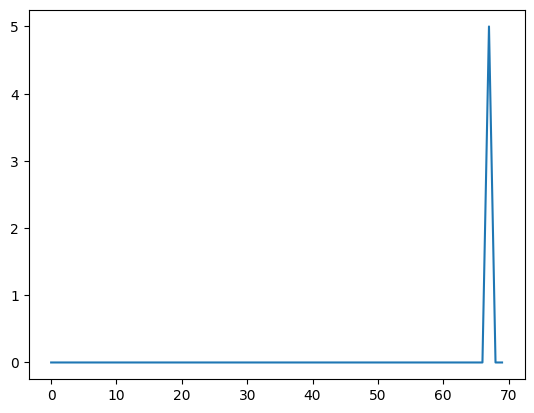

In [12]:
pd.Series(synth_data["variable_power_kW_test_charging_schedule"].iloc[0]).plot()